# Data Collection


In [45]:
import requests
import pandas as pd
import numpy as np


In [19]:
import time
time.sleep(1)  

API_KEY = "e61bdc280ee72926adbd94ad62932b67"


BASE_URL = "https://api.themoviedb.org/3/movie/popular"


GENRES_URL = f"https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}&language=en-US"


def fetch_genres(api_key):
    response = requests.get(GENRES_URL)
    if response.status_code == 200:
        data = response.json()
        return {genre['id']: genre['name'] for genre in data['genres']}
    else:
        print(f"Ошибка при загрузке жанров: {response.status_code}")
        return {}


def fetch_movie_details(movie_id, api_key):
    movie_details_url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&language=en-US"
    credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api_key}&language=en-US"
    keywords_url = f"https://api.themoviedb.org/3/movie/{movie_id}/keywords?api_key={api_key}&language=en-US"

    details_response = requests.get(movie_details_url)
    credits_response = requests.get(credits_url)
    keywords_response = requests.get(keywords_url)

    if details_response.status_code == 200 and credits_response.status_code == 200 and keywords_response.status_code == 200:
        details_data = details_response.json()
        credits_data = credits_response.json()
        keywords_data = keywords_response.json()

        #
        tagline = details_data.get('tagline', '')
        keywords = ', '.join([kw['name'] for kw in keywords_data['keywords']])
        cast = ', '.join([actor['name'] for actor in credits_data['cast'][:5]])  # Ограничиваем первыми 5 актерами
        director = ', '.join([person['name'] for person in credits_data['crew'] if person['job'] == 'Director'])

        return {'keywords': keywords, 'tagline': tagline, 'cast': cast, 'director': director}
    else:
        print(f"Ошибка получения данных для фильма с ID {movie_id}")
        return {'keywords': '', 'tagline': '', 'cast': '', 'director': ''}


def fetch_movies(api_key, genres_map, max_rows=100):
    all_movies = []  
    total_rows = 0  
    page = 1         

    while total_rows < max_rows:
        
        url = f"{BASE_URL}?api_key={api_key}&language=en-US&page={page}"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            movies = data['results']  

            for movie in movies:
                
                title = movie.get('title', None)
                release_date = movie.get('release_date', None)
                release_year = release_date.split('-')[0] if release_date else None
                imdb_rating = movie.get('vote_average', None)
                vote_count = movie.get('vote_count', None)
                description = movie.get('overview', None)
                poster_url = f"https://image.tmdb.org/t/p/w500{movie['poster_path']}" if movie.get('poster_path') else None

                
                genre_ids = movie.get('genre_ids', [])
                genres = [genres_map.get(genre_id, "Unknown") for genre_id in genre_ids]

                
                movie_details = fetch_movie_details(movie['id'], api_key)

                
                all_movies.append({
                    'Movie Title': title,
                    'Genre(s)': ', '.join(genres),
                    'Release Year': release_year,
                    'IMDb Rating': imdb_rating,
                    'Number of Votes': vote_count,
                    'Movie Description': description,
                    'Poster URL': poster_url,
                    'Keywords': movie_details['keywords'],
                    'Tagline': movie_details['tagline'],
                    'Cast': movie_details['cast'],
                    'Director': movie_details['director']
                })
                total_rows += 1

                
                if total_rows >= max_rows:
                    break

            
            if page >= data['total_pages']:
                break

            page += 1  
        else:
            print(f"Ошибка: {response.status_code}, страница {page}")
            break

    return all_movies



genres_map = fetch_genres(API_KEY)


movies_data = fetch_movies(API_KEY, genres_map, max_rows=4000)


df = pd.DataFrame(movies_data)


df.to_csv("movies_with_additional_featuresBat.csv", index=False)


print(df.head())
print(f"Всего строк: {len(df)}")

             Movie Title                              Genre(s) Release Year  \
0  Venom: The Last Dance    Action, Science Fiction, Adventure         2024   
1                Moana 2  Animation, Adventure, Family, Comedy         2024   
2              Elevation     Action, Science Fiction, Thriller         2024   
3             Absolution               Action, Crime, Thriller         2024   
4                  Armor               Action, Crime, Thriller         2024   

   IMDb Rating  Number of Votes  \
0          6.7             1233   
1          6.9              436   
2          6.4              128   
3          6.0              121   
4          5.6               55   

                                   Movie Description  \
0  Eddie and Venom are on the run. Hunted by both...   
1  After receiving an unexpected call from her wa...   
2  A single father and two women venture from the...   
3  An aging ex-boxer gangster working as muscle f...   
4  Armored truck security guard Ja

In [46]:
df=pd.read_csv(r"movies_with_additional_featuresBat.csv")
df.head(3)

,Movie Title,Genre(s),Release Year,IMDb Rating,Number of Votes,Movie Description,Poster URL,Keywords,Tagline,Cast,Director
0,Venom: The Last Dance,"Action, Science Fiction, Adventure",2024.0,6.7,1233,Eddie and Venom are on the run. Hunted by both...,https://image.tmdb.org/t/p/w500/aosm8NMQ3UyoBV...,"hero, superhero, anti hero, villain, alien lif...",'Til death do they part.,"Tom Hardy, Chiwetel Ejiofor, Juno Temple, Clar...",Kelly Marcel
1,Moana 2,"Animation, Adventure, Family, Comedy",2024.0,6.9,436,After receiving an unexpected call from her wa...,https://image.tmdb.org/t/p/w500/yh64qw9mgXBvla...,"sea, ocean, villain, musical, sequel",The ocean is calling them back.,"Auliʻi Cravalho, Dwayne Johnson, Hualālai Chun...","David G. Derrick Jr., Jason Hand, Dana Ledoux ..."
2,Elevation,"Action, Science Fiction, Thriller",2024.0,6.4,128,A single father and two women venture from the...,https://image.tmdb.org/t/p/w500/uQhYBxOVFU6s9a...,"mine, colorado, hospital, alien invasion, ski ...",Don't go down without a fight.,"Anthony Mackie, Morena Baccarin, Maddie Hasson...",George Nolfi


# Milestone 2: Data Cleaning and Preprocessing


In [47]:
df.isnull().sum()

Movie Title            0
Genre(s)               9
Release Year           9
IMDb Rating            0
Number of Votes        0
Movie Description     24
Poster URL             2
Keywords             307
Tagline              758
Cast                  23
Director              21
dtype: int64

In [48]:
md=df['Release Year'].mode().iloc[0]
df['Release Year']=df['Release Year'].fillna(md)
df.isnull().sum()

Movie Title            0
Genre(s)               9
Release Year           0
IMDb Rating            0
Number of Votes        0
Movie Description     24
Poster URL             2
Keywords             307
Tagline              758
Cast                  23
Director              21
dtype: int64

In [49]:
nl='nulll'
df['Poster URL']=df['Poster URL'].fillna(nl)
df.isnull().sum()

Movie Title            0
Genre(s)               9
Release Year           0
IMDb Rating            0
Number of Votes        0
Movie Description     24
Poster URL             0
Keywords             307
Tagline              758
Cast                  23
Director              21
dtype: int64

In [50]:

df = df.drop_duplicates()


print(f"Количество строк после удаления дубликатов: {len(df)}")


Количество строк после удаления дубликатов: 3247


In [51]:

selected_features = ['Genre(s)','Keywords','Tagline','Cast','Director','Movie Description']
print(selected_features)

for feature in selected_features:
  df[feature] = df[feature].fillna('')


['Genre(s)', 'Keywords', 'Tagline', 'Cast', 'Director', 'Movie Description']


In [52]:
df.isnull().sum()

Movie Title          0
Genre(s)             0
Release Year         0
IMDb Rating          0
Number of Votes      0
Movie Description    0
Poster URL           0
Keywords             0
Tagline              0
Cast                 0
Director             0
dtype: int64

In [53]:
df_genres = df["Genre(s)"].str.get_dummies(sep=', ').astype(int)  


df1 = pd.concat([df.drop(columns=["Genre(s)"]), df_genres], axis=1)
df1


,Movie Title,Release Year,IMDb Rating,Number of Votes,Movie Description,Poster URL,Keywords,Tagline,Cast,Director,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Venom: The Last Dance,2024.0,6.700,1233,Eddie and Venom are on the run. Hunted by both...,https://image.tmdb.org/t/p/w500/aosm8NMQ3UyoBV...,"hero, superhero, anti hero, villain, alien lif...",'Til death do they part.,"Tom Hardy, Chiwetel Ejiofor, Juno Temple, Clar...",Kelly Marcel,...,0,0,0,0,0,1,0,0,0,0
1,Moana 2,2024.0,6.900,436,After receiving an unexpected call from her wa...,https://image.tmdb.org/t/p/w500/yh64qw9mgXBvla...,"sea, ocean, villain, musical, sequel",The ocean is calling them back.,"Auliʻi Cravalho, Dwayne Johnson, Hualālai Chun...","David G. Derrick Jr., Jason Hand, Dana Ledoux ...",...,0,0,0,0,0,0,0,0,0,0
2,Elevation,2024.0,6.400,128,A single father and two women venture from the...,https://image.tmdb.org/t/p/w500/uQhYBxOVFU6s9a...,"mine, colorado, hospital, alien invasion, ski ...",Don't go down without a fight.,"Anthony Mackie, Morena Baccarin, Maddie Hasson...",George Nolfi,...,0,0,0,0,0,1,0,1,0,0
3,Absolution,2024.0,6.000,121,An aging ex-boxer gangster working as muscle f...,https://image.tmdb.org/t/p/w500/cNtAslrDhk1i3I...,gangster,Everyone pays in the end.,"Liam Neeson, Ron Perlman, Yolonda Ross, Franki...",Hans Petter Moland,...,0,0,0,0,0,0,0,1,0,0
4,Armor,2024.0,5.600,55,Armored truck security guard James Brody is wo...,https://image.tmdb.org/t/p/w500/pnXLFioDeftqjl...,armored truck,On the bridge of death.,"Sylvester Stallone, Jason Patric, Josh Wiggins...",Justin Routt,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,R-Rated Idol Seung-ha's Fancy Walk,2020.0,7.700,15,Seo-yeon is being tutored by Woo-hyeon who is ...,https://image.tmdb.org/t/p/w500/l0jd4v2490rC9o...,softcore,,"Seung Ha, Seo Bo-ra, Si Hoo, Gil Dong",Choi Jin-chul,...,0,0,0,0,1,0,0,0,0,0
3996,The Greatest of All Time,2024.0,4.900,14,A once decorated member of the Special Anti-Te...,https://image.tmdb.org/t/p/w500/r5FjbUg5Ei9I1q...,"covert agency, dual role, science fiction",A Venkat Prabhu Hero,"Vijay, Prashanth, Prabhu Deva, Ajmal Ameer, Mohan",Venkat Prabhu,...,0,0,0,0,0,0,0,1,0,0
3997,The Faculty,1998.0,6.500,1970,When some very creepy things start happening a...,https://image.tmdb.org/t/p/w500/5XetJwmAiDC0Et...,"drug dealer, high school, homophobia, paranoia...",Take me to your teacher.,"Jordana Brewster, Clea DuVall, Laura Harris, J...",Robert Rodriguez,...,0,1,0,1,0,1,0,0,0,0
3998,G-Force,2009.0,5.449,1856,"A team of trained secret agent animals, guinea...",https://image.tmdb.org/t/p/w500/fkqcF21HKZPvCw...,"secret agent, guinea pig, dyr, duringcreditsst...",The world needs bigger heroes,"Sam Rockwell, Jon Favreau, Tracy Morgan, Penél...",Hoyt Yeatman,...,0,0,0,0,0,0,0,0,0,0


# Milestone 3: Exploratory Data Analysis (EDA)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df1.describe()


,Release Year,IMDb Rating,Number of Votes,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,...,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000
mean,2010.530008,6.594272,3247.097168,0.332814,0.226552,0.135360,0.293583,0.126526,0.008574,0.351000,...,0.040790,0.157184,0.018706,0.076383,0.148870,0.146272,0.017407,0.275656,0.029098,0.013770
std,14.900020,1.220134,4534.337833,0.471282,0.418655,0.342152,0.455462,0.332485,0.092208,0.477345,...,0.197829,0.364021,0.135503,0.265645,0.356006,0.353424,0.130800,0.446902,0.168104,0.116549
min,1921.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,6.143000,237.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,6.700000,1533.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2022.000000,7.300000,4377.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,2027.000000,10.000000,36635.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:

mean_rating = df1['IMDb Rating'].mean()
median_rating = df1['IMDb Rating'].median()
std_rating = df1['IMDb Rating'].std()

print(f"Средний рейтинг: {mean_rating}")
print(f"Медиана рейтинга: {median_rating}")
print(f"Стандартное отклонение: {std_rating}")


Средний рейтинг: 6.594272278513899
Медиана рейтинга: 6.7
Стандартное отклонение: 1.2201342293336055


C:\Users\Asus\AppData\Local\Temp\ipykernel_17348\4234322933.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


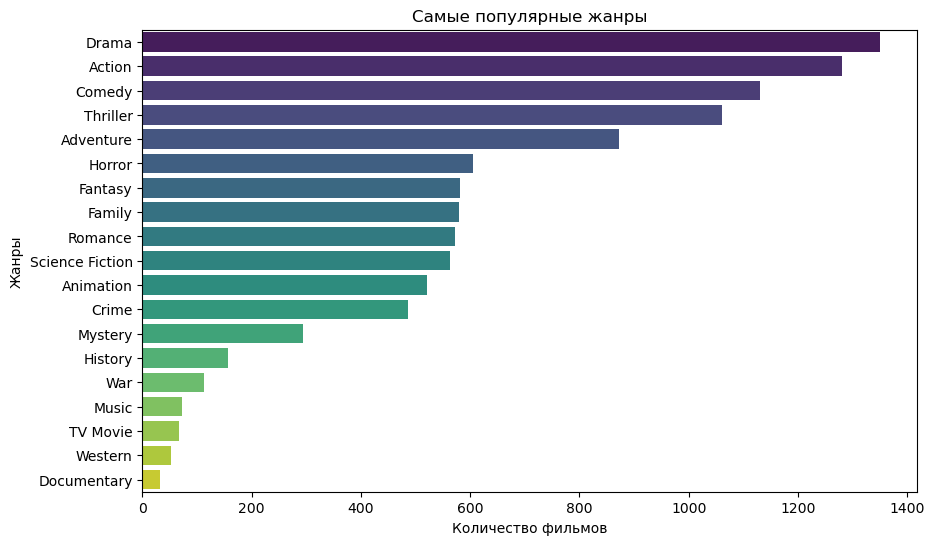

In [33]:
genre_counts = df.iloc[:, 6:].sum().sort_values(ascending=False) 

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title("Самые популярные жанры")
plt.xlabel("Количество фильмов")
plt.ylabel("Жанры")
plt.show()


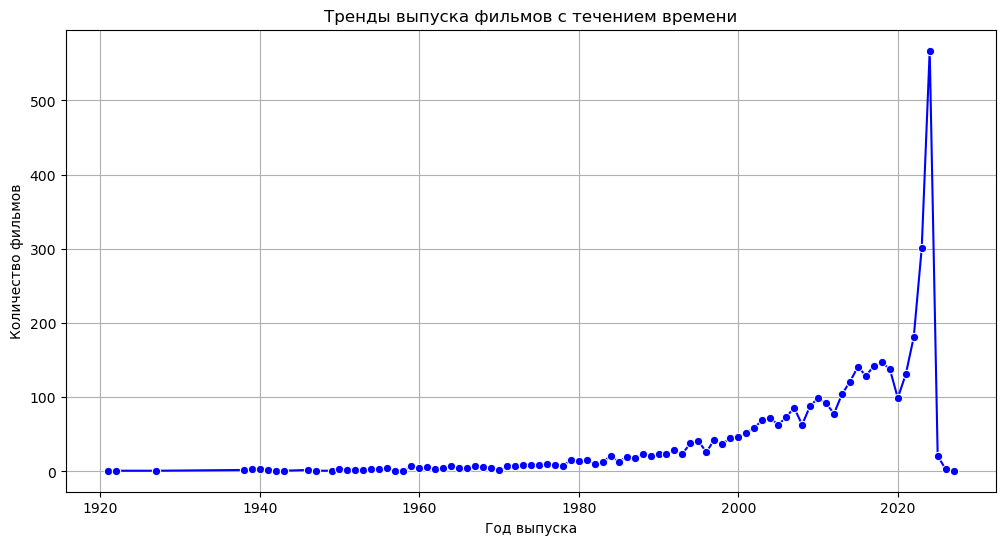

In [34]:

release_trend = df['Release Year'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
sns.lineplot(x=release_trend.index, y=release_trend.values, marker='o', color='b')
plt.title("Тренды выпуска фильмов с течением времени")
plt.xlabel("Год выпуска")
plt.ylabel("Количество фильмов")
plt.grid(True)
plt.show()


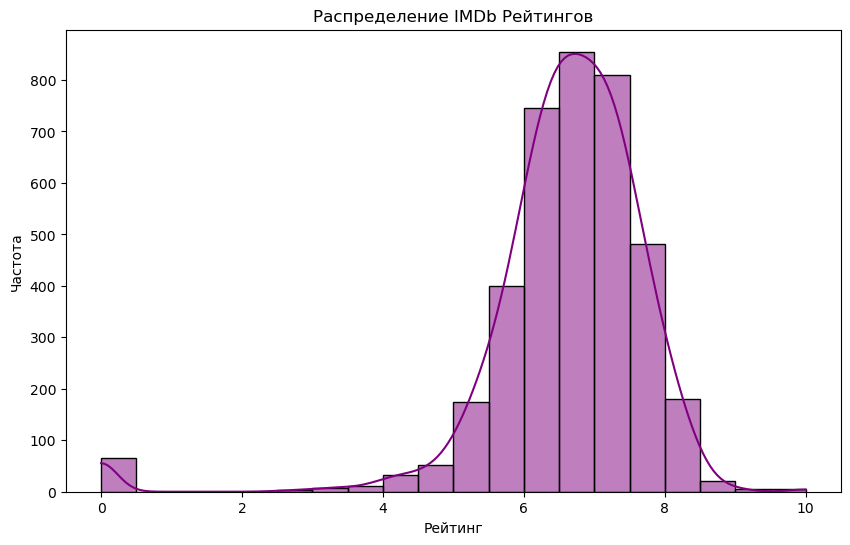

In [35]:

plt.figure(figsize=(10, 6))
sns.histplot(df['IMDb Rating'], kde=True, bins=20, color='purple')
plt.title("Распределение IMDb Рейтингов")
plt.xlabel("Рейтинг")
plt.ylabel("Частота")
plt.show()


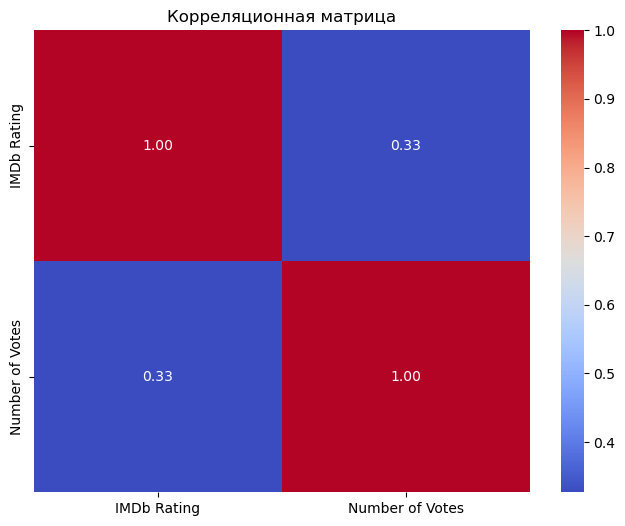

In [36]:

correlation_matrix = df[['IMDb Rating', 'Number of Votes']].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_17348\3106434480.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Decade', data=df, palette='viridis')


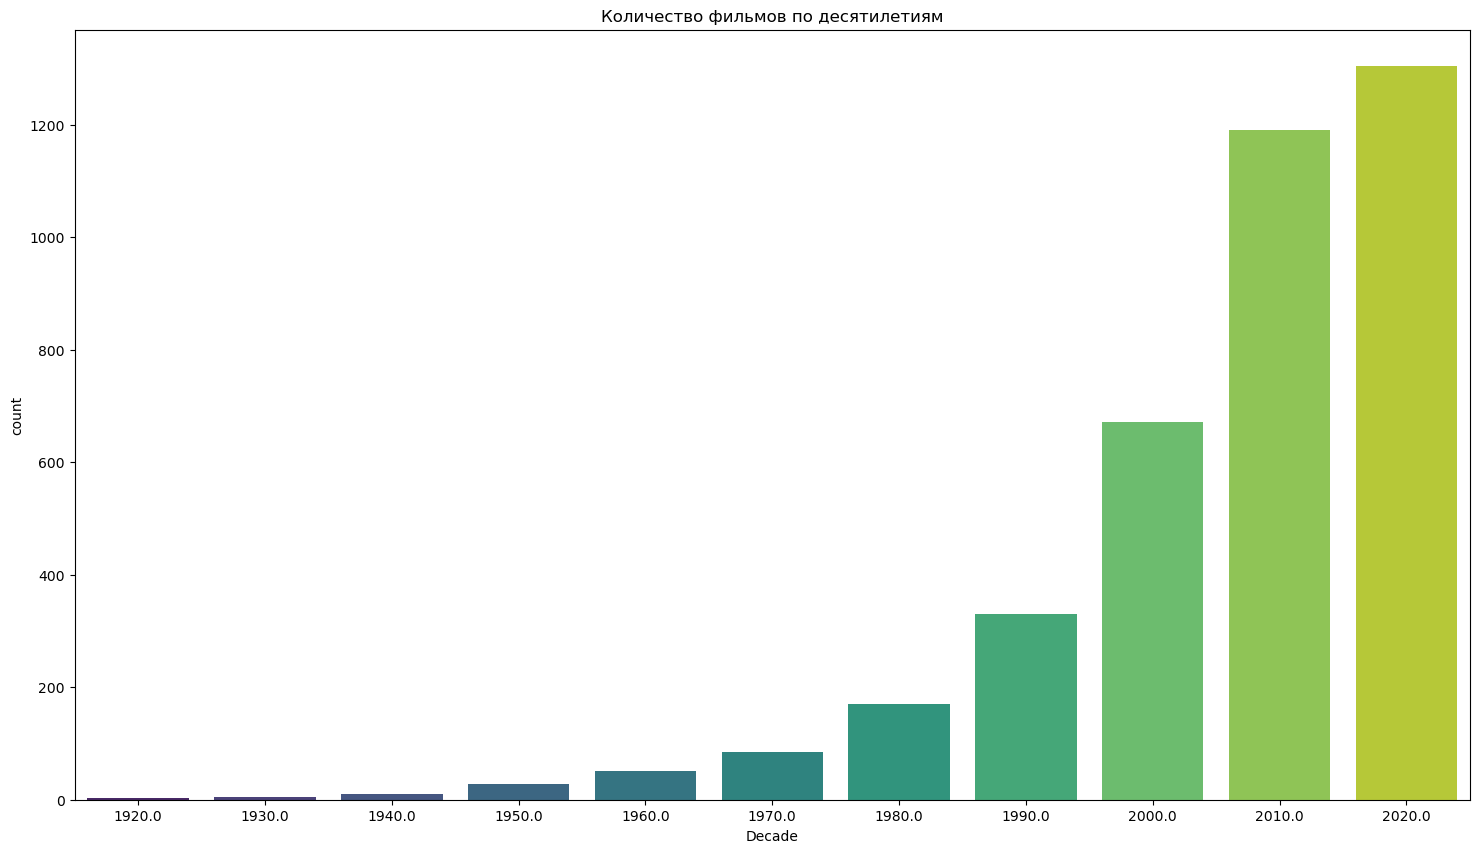

In [42]:
df['Decade'] = (df['Release Year'] // 10) * 10  
plt.figure(figsize=(18, 10))
sns.countplot(x='Decade', data=df, palette='viridis')
plt.title("Количество фильмов по десятилетиям")
plt.show()


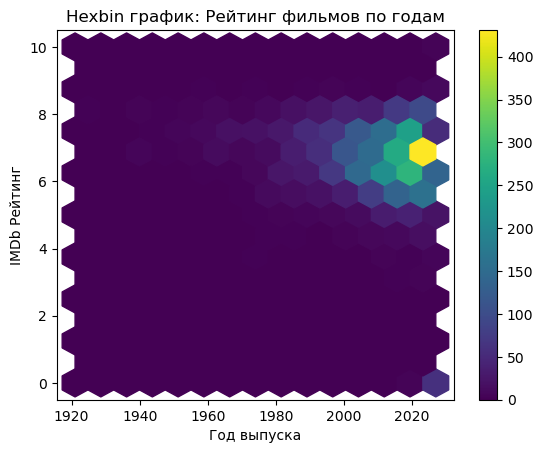

In [44]:



df.plot.hexbin(x='Release Year', y='IMDb Rating', gridsize=14, cmap='viridis')


plt.title("Hexbin график: Рейтинг фильмов по годам")
plt.xlabel("Год выпуска")
plt.ylabel("IMDb Рейтинг")
plt.show()


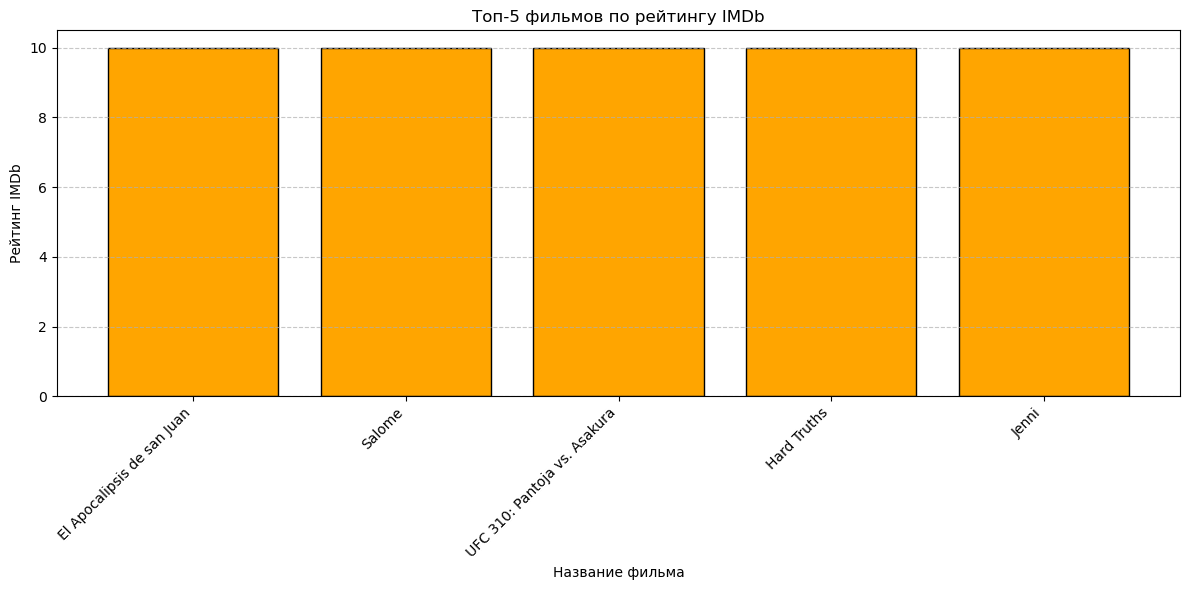

In [45]:


top5_movies = df.nlargest(5, 'IMDb Rating')


plt.figure(figsize=(12, 6))
plt.bar(top5_movies['Movie Title'], top5_movies['IMDb Rating'], color='orange', edgecolor='black')
plt.title("Топ-5 фильмов по рейтингу IMDb")
plt.xlabel("Название фильма")
plt.ylabel("Рейтинг IMDb")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Milestone 4: Linear Regression Model for Rating Prediction


In [7]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
numerical_columns = ['Release Year','IMDb Rating', 'Number of Votes']


df1[numerical_columns] = scaler.fit_transform(df1[numerical_columns])


df1.head(2)


,Movie Title,Release Year,IMDb Rating,Number of Votes,Movie Description,Poster URL,Keywords,Tagline,Cast,Director,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Venom: The Last Dance,0.885127,0.113639,-0.414985,Eddie and Venom are on the run. Hunted by both...,https://image.tmdb.org/t/p/w500/aosm8NMQ3UyoBV...,"hero, superhero, anti hero, villain, alien lif...",'Til death do they part.,"Tom Hardy, Chiwetel Ejiofor, Juno Temple, Clar...",Kelly Marcel,...,0,0,0,0,0,1,0,0,0,0
1,Moana 2,0.885127,0.266472,-0.586691,After receiving an unexpected call from her wa...,https://image.tmdb.org/t/p/w500/yh64qw9mgXBvla...,"sea, ocean, villain, musical, sequel",The ocean is calling them back.,"Auliʻi Cravalho, Dwayne Johnson, Hualālai Chun...","David G. Derrick Jr., Jason Hand, Dana Ledoux ...",...,0,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

In [18]:
df1.head(1)

,Movie Title,Release Year,IMDb Rating,Number of Votes,Movie Description,Poster URL,Keywords,Tagline,Cast,Director,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Venom: The Last Dance,0.885127,0.113639,-0.414985,Eddie and Venom are on the run. Hunted by both...,https://image.tmdb.org/t/p/w500/aosm8NMQ3UyoBV...,"hero, superhero, anti hero, villain, alien lif...",'Til death do they part.,"Tom Hardy, Chiwetel Ejiofor, Juno Temple, Clar...",Kelly Marcel,...,0,0,0,0,0,1,0,0,0,0


In [25]:
X = df1.drop(columns=['Movie Title','Movie Description','Poster URL','Keywords','Tagline','IMDb Rating','Cast','Director']) #its qualitative and 

Y = df1['IMDb Rating']

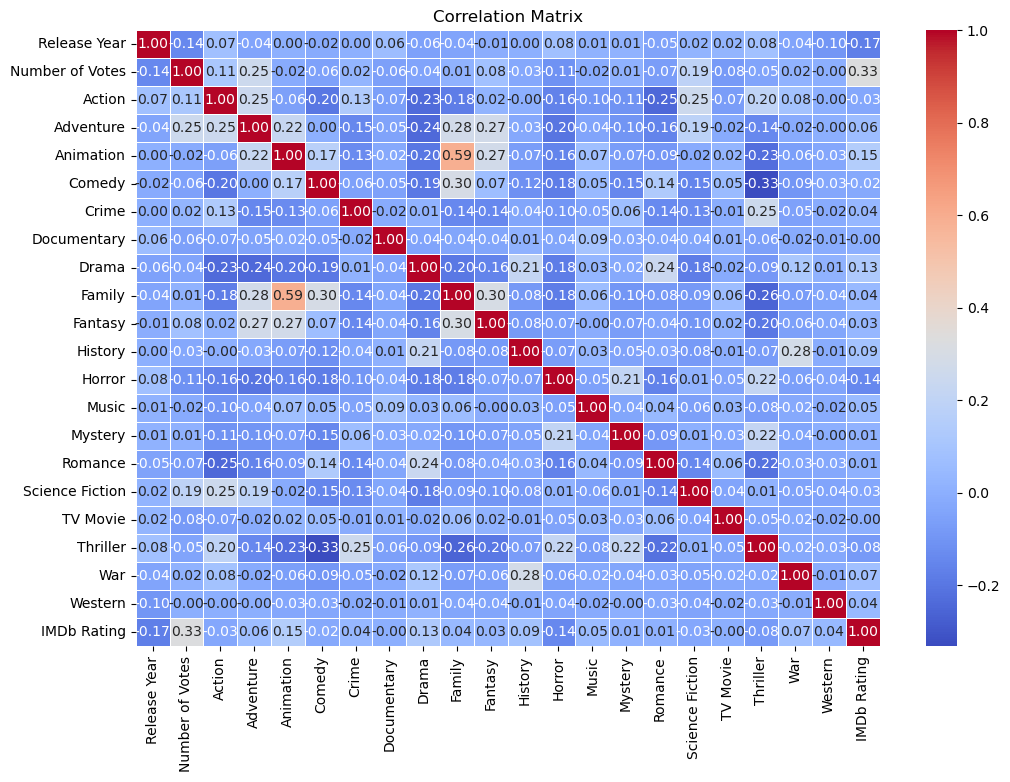

In [12]:
X_with_Y = X.copy()
X_with_Y['IMDb Rating'] = Y


correlation_matrix = X_with_Y.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
X_train

,Release Year,Number of Votes,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
968,0.167017,3.045852,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
823,0.558713,1.178198,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3688,-1.987313,-0.582598,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2275,0.167017,-0.030208,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3521,-0.224680,0.677299,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.232300,0.139775,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1408,0.885127,-0.679546,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1596,-1.138638,-0.237893,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0.623996,1.133386,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
linear_reg = LinearRegression()

In [53]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [54]:
from sklearn.metrics import mean_squared_error

def model_evaluation(linear_reg, X_test, y_test, model_name):
    y_pred = linear_reg.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test, y_test, 'Linear Reg.')

,Linear Reg.
MAE,0.539578
MSE,0.784771
RMSE,0.885873
R2-Score,0.198456


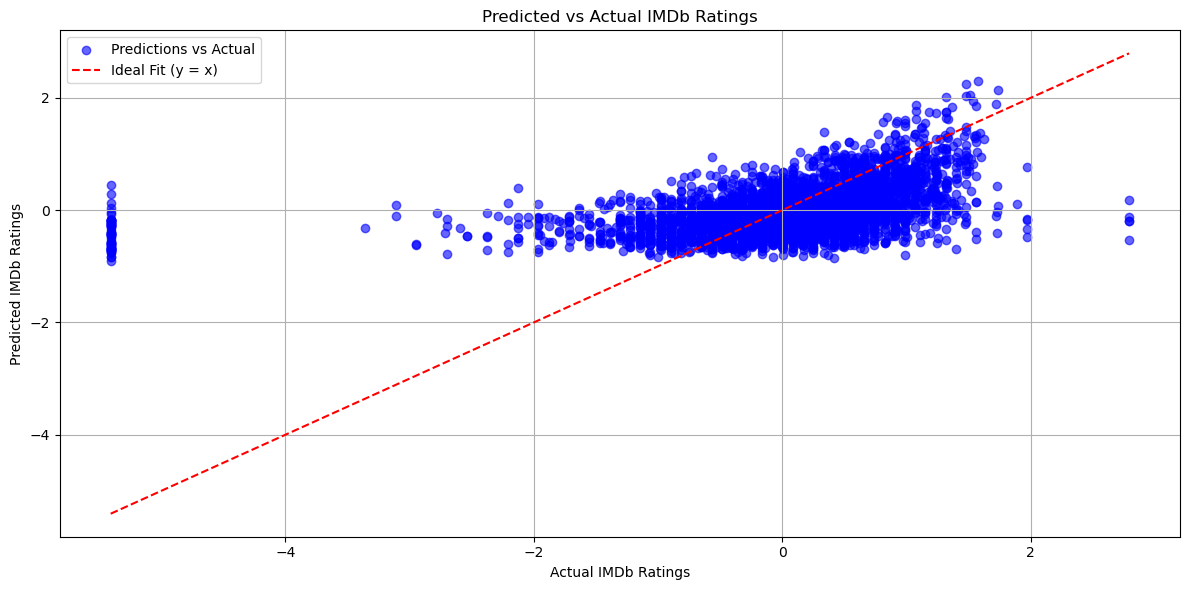

In [57]:
predictions = linear_reg.predict(X)
plt.figure(figsize=(12, 6))
plt.scatter(Y, predictions, color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', label='Ideal Fit (y = x)')


plt.xlabel("Actual IMDb Ratings")
plt.ylabel("Predicted IMDb Ratings")
plt.title("Predicted vs Actual IMDb Ratings")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Extra Credit  neural network for prediction

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error



mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', max_iter=500, random_state=42)


mlp.fit(X_train, y_train)


y_pred = mlp.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



Mean Absolute Error (MAE): 0.51
Root Mean Squared Error (RMSE): 0.86


# Milestone 5: Building a Simple Recommendation System


In [27]:
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
df.isnull().sum()

Movie Title            0
Genre(s)               7
Release Year           0
IMDb Rating            0
Number of Votes        0
Movie Description     20
Poster URL             0
Keywords             245
Tagline              625
Cast                  17
Director              17
dtype: int64

In [35]:


combined_features = df['Genre(s)']+' '+df['Keywords']+' '+df['Tagline']+' '+df['Cast']+' '+df['Director']+' '+df['Movie Description']


combined_features = combined_features.str.lower().str.strip()

print(combined_features)

0       action, science fiction, adventure hero, super...
1       animation, adventure, family, comedy sea, ocea...
2       action, science fiction, thriller mine, colora...
3       action, crime, thriller gangster everyone pays...
4       action, crime, thriller armored truck on the b...
                              ...                        
3995    drama, romance softcore  seung ha, seo bo-ra, ...
3996    action, drama, thriller covert agency, dual ro...
3997    horror, science fiction, mystery drug dealer, ...
3998    animation, family, fantasy, action, adventure,...
3999    comedy diplomat, dream, nightmare, upper class...
Length: 3247, dtype: object


In [36]:


vectorizer = TfidfVectorizer(stop_words='english')

In [37]:
feature_vectors = vectorizer.fit_transform(combined_features)


In [12]:
print(feature_vectors)

  (0, 6064)	0.13271763640665582
  (0, 5934)	0.20140368666249617
  (0, 3461)	0.12143866115586333
  (0, 6286)	0.1530507806691656
  (0, 6675)	0.15840569802732715
  (0, 9150)	0.10197825432134151
  (0, 7420)	0.14737800920220842
  (0, 4892)	0.1653093872190203
  (0, 17064)	0.1750395906362812
  (0, 26996)	0.13341326871804784
  (0, 11614)	0.1438598726300633
  (0, 21049)	0.10752438890140284
  (0, 26019)	0.38334696649047045
  (0, 7575)	0.26543527281331164
  (0, 15183)	0.19167348324523523
  (0, 13269)	0.12143866115586333
  (0, 11768)	0.17941487669538056
  (0, 20572)	0.14867549461006624
  (0, 2050)	0.20140368666249617
  (0, 4779)	0.14177180541837311
  (0, 24405)	0.15470644637377143
  (0, 12958)	0.1847697940535421
  (0, 7681)	0.15840569802732715
  (0, 4614)	0.15840569802732715
  (0, 10717)	0.14867549461006624
  :	:
  (3246, 24167)	0.1098848128239552
  (3246, 25034)	0.1020482680509287
  (3246, 24477)	0.09617116858653937
  (3246, 6162)	0.09913411510244881
  (3246, 20441)	0.10024300432395314
  (3246, 2

In [38]:


similarity = cosine_similarity(feature_vectors)

In [14]:
print(similarity)

[[1.         0.02236591 0.03098805 ... 0.04371119 0.01255673 0.        ]
 [0.02236591 1.         0.01405613 ... 0.         0.02192796 0.01369972]
 [0.03098805 0.01405613 1.         ... 0.06297881 0.01019152 0.        ]
 ...
 [0.04371119 0.         0.06297881 ... 1.         0.         0.00654425]
 [0.01255673 0.02192796 0.01019152 ... 0.         1.         0.00344378]
 [0.         0.01369972 0.         ... 0.00654425 0.00344378 1.        ]]


In [15]:
print(similarity.shape)

(3247, 3247)


In [ ]:



def recommend_movies(movie_name, num_recommendations=10):
   
    list_of_all_titles = df['Movie Title'].tolist()

   
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

    
    if not find_close_match:
        print("Sorry, no close match found for the movie name.")
        return

   
    close_match = find_close_match[0]
    print(f"Closest match found: {close_match}")

    
    index_of_the_movie = df[df['Movie Title'] == close_match].index[0]

    
    similarity_score = list(enumerate(similarity[index_of_the_movie]))

    
    sorted_similar_movies = sorted(similarity_score, key=lambda x: (x[1], df['IMDb Rating'].iloc[x[0]]), reverse=True)

    
    print("\nMovies suggested for you:\n")
    i = 1
    for movie in sorted_similar_movies[1:num_recommendations + 1]:  
        index = movie[0]
        title_from_index = df['Movie Title'].iloc[index]
        print(f"{i}. {title_from_index}")
        i += 1


movie_name = input("Enter your favourite movie name: ")
recommend_movies(movie_name, num_recommendations=10)


df.to_csv("movies_with_additional_featuresBatsql.csv", index=False)


# Milestone 6: Data Storage and Access


In [40]:
import pandas as pd
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData, select, update
import sqlite3

In [42]:
movies_data = pd.read_csv(r"C:\Users\Asus\Downloads\movies_with_additional_featuresBat.csv")
movies_data.reset_index(inplace=True)


In [43]:
movies_data.columns

Index(['index', 'Movie Title', 'Genre(s)', 'Release Year', 'IMDb Rating',
       'Number of Votes', 'Movie Description', 'Poster URL', 'Keywords',
       'Tagline', 'Cast', 'Director'],
      dtype='object')

In [44]:
import pandas as pd
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData, select, update


movies_data.columns = [
    'index', 'Movie_Title', 'Genre', 'Release_Year', 'IMDb_Rating',
    'Number_of_Votes', 'Movie_Description', 'Poster_URL', 'Keywords',
    'Tagline', 'Cast', 'Director'
]


engine = create_engine('sqlite:///movies_database.db')
metadata = MetaData()


movies_table = Table(
    'movies', metadata,
    Column('index', Integer, primary_key=True),
    Column('Movie_Title', String),
    Column('Genre', String),
    Column('Release_Year', Integer),
    Column('IMDb_Rating', Float),
    Column('Number_of_Votes', Integer),
    Column('Movie_Description', String),
    Column('Poster_URL', String),
    Column('Keywords', String),
    Column('Tagline', String),
    Column('Cast', String),
    Column('Director', String)
)

metadata.create_all(engine)


movies_data.to_sql('movies', con=engine, if_exists='replace', index=False)
print("✅ База данных создана и данные успешно сохранены!")


def fetch_all_movies():
    with engine.connect() as connection:
        result = connection.execute(select(movies_table))
        for row in result:
            print(row)


def fetch_movie_by_title(title):
    with engine.connect() as connection:
        query = select(movies_table).where(movies_table.c.Movie_Title == title)
        result = connection.execute(query).fetchall()
        if result:
            for row in result:
                print(row)
        else:
            print("❌ Фильм не найден.")


def update_movie_rating(title, new_rating):
    with engine.connect() as connection:
        query = update(movies_table).where(movies_table.c.Movie_Title == title).values(IMDb_Rating=new_rating)
        result = connection.execute(query)
        if result.rowcount > 0:
            print(f"✅ Рейтинг фильма '{title}' обновлён до {new_rating}.")
        else:
            print("❌ Фильм не найден или рейтинг не обновлён.")


def add_new_movie(movie_data):
    with engine.connect() as connection:
        connection.execute(movies_table.insert(), movie_data)
        print(f"✅ Фильм '{movie_data['Movie_Title']}' успешно добавлен.")


def delete_movie_by_title(title):
    with engine.connect() as connection:
        result = connection.execute(movies_table.delete().where(movies_table.c.Movie_Title == title))
        if result.rowcount > 0:
            print(f"✅ Фильм '{title}' успешно удалён.")
        else:
            print("❌ Фильм не найден или не был удалён.")



def get_recommendations_by_genre(genre, limit=5):
    with engine.connect() as connection:
        query = select(movies_table).where(movies_table.c.Genre.like(f"%{genre}%")).limit(limit)
        result = connection.execute(query).fetchall()
        if result:
            print(f"\n🎬 Рекомендованные фильмы в жанре '{genre}':\n")
            for row in result:
                print(f"{row['Movie_Title']} ({row['Release_Year']}) - IMDb Rating: {row['IMDb_Rating']}")
        else:
            print(f"❌ Нет рекомендаций для жанра '{genre}'.")



if __name__ == "__main__":
    
    print("\n📋 Получение всех фильмов (первые 5 записей):")
    fetch_all_movies()
    
   
    print("\n🔍 Получение информации о фильме 'Inception':")
    fetch_movie_by_title('Inception')

    
    print("\n✏️ Обновление рейтинга фильма 'Inception':")
    update_movie_rating('Inception', 9.0)

    
    new_movie = {
        'Movie_Title': 'New Awesome Movie',
        'Genre': 'Action, Adventure',
        'Release_Year': 2024,
        'IMDb_Rating': 8.5,
        'Number_of_Votes': 1200,
        'Movie_Description': 'An epic adventure of heroes.',
        'Poster_URL': 'http://example.com/poster.jpg',
        'Keywords': 'hero, adventure, action',
        'Tagline': 'A new legend is born.',
        'Cast': 'John Doe, Jane Smith',
        'Director': 'Jane Director'
    }
    print("\n➕ Добавление нового фильма:")
    add_new_movie(new_movie)

  
    print("\n🗑️ Удаление фильма 'New Awesome Movie':")
    delete_movie_by_title('New Awesome Movie')

    
    print("\n🎥 Получение рекомендаций для жанра 'Action':")
    get_recommendations_by_genre('Action', limit=5)


✅ База данных создана и данные успешно сохранены!

📋 Получение всех фильмов (первые 5 записей):
(0, 'Venom: The Last Dance', 'Action, Science Fiction, Adventure', 2024.0, 6.7, 1233, "Eddie and Venom are on the run. Hunted by both of their worlds and with the net closing in, the duo are forced into a devastating decision that will bring the curtains down on Venom and Eddie's last dance.", 'https://image.tmdb.org/t/p/w500/aosm8NMQ3UyoBVpSxyimorCQykC.jpg', 'hero, superhero, anti hero, villain, alien life-form, based on comic, sequel, aftercreditsstinger, woman director, bitter', "'Til death do they part.", 'Tom Hardy, Chiwetel Ejiofor, Juno Temple, Clark Backo, Rhys Ifans', 'Kelly Marcel')
(1, 'Moana 2', 'Animation, Adventure, Family, Comedy', 2024.0, 6.9, 436, "After receiving an unexpected call from her wayfinding ancestors, Moana journeys alongside Maui and a new crew to the far seas of Oceania and into dangerous, long-lost waters for an adventure unlike anything she's ever faced.", 'h

TypeError: tuple indices must be integers or slices, not str

In [30]:
fetch_movie_by_title('Moana 2')


(1, 'Moana 2', 'Animation, Adventure, Family, Comedy', 2024.0, 6.9, 436, "After receiving an unexpected call from her wayfinding ancestors, Moana journeys alongside Maui and a new crew to the far seas of Oceania and into dangerous, long-lost waters for an adventure unlike anything she's ever faced.", 'https://image.tmdb.org/t/p/w500/yh64qw9mgXBvlaWDi7Q9tpUBAvH.jpg', 'sea, ocean, villain, musical, sequel', 'The ocean is calling them back.', 'Auliʻi Cravalho, Dwayne Johnson, Hualālai Chung, Rose Matafeo, David Fane', 'David G. Derrick Jr., Jason Hand, Dana Ledoux Miller')


In [31]:
update_movie_rating('Moana 2', 8.5)


✅ Рейтинг фильма 'Moana 2' обновлён до 8.5.


In [32]:
new_movie = {
    'Movie_Title': 'Example Movie',
    'Genre': 'Drama, Thriller',
    'Release_Year': 2023,
    'IMDb_Rating': 7.8,
    'Number_of_Votes': 1500,
    'Movie_Description': 'A thrilling example of a new movie.',
    'Poster_URL': 'http://example.com/poster.jpg',
    'Keywords': 'thriller, drama, suspense',
    'Tagline': 'Expect the unexpected.',
    'Cast': 'John Doe, Jane Smith',
    'Director': 'John Director'
}
add_new_movie(new_movie)


✅ Фильм 'Example Movie' успешно добавлен.


In [34]:
def get_recommendations_by_genre(genre, limit=5):
    with engine.connect() as connection:
        query = select(movies_table).where(movies_table.c.Genre.like(f"%{genre}%")).limit(limit)
        result = connection.execute(query).fetchall()
        if result:
            print(f"\n🎬 Рекомендованные фильмы в жанре '{genre}':\n")
            for row in result:
                
                print(f"{row[1]} ({row[3]}) - IMDb Rating: {row[4]}")
        else:
            print(f"❌ Нет рекомендаций для жанра '{genre}'.")


In [35]:
get_recommendations_by_genre('Action', limit=5)



🎬 Рекомендованные фильмы в жанре 'Action':

Venom: The Last Dance (2024.0) - IMDb Rating: 6.7
Elevation (2024.0) - IMDb Rating: 6.4
Absolution (2024.0) - IMDb Rating: 6.0
Armor (2024.0) - IMDb Rating: 5.6
Gladiator II (2024.0) - IMDb Rating: 6.7


# Milestone 7: Interactive Interface for Recommendations (Optional)


In [36]:
import streamlit as st
from sqlalchemy import create_engine, select, Table, MetaData
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
import pandas as pd
import streamlit as st
from sqlalchemy import create_engine, select, Table, MetaData
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


engine = create_engine('sqlite:///movies_database.db')
metadata = MetaData()
movies_table = Table('movies', metadata, autoload_with=engine)


def load_movies():
    with engine.connect() as connection:
        query = select(movies_table)
        result = connection.execute(query)
        return pd.DataFrame(result.fetchall(), columns=result.keys())


movies_data = load_movies()


movies_data['combined_features'] = (
    movies_data['Genre'].fillna('') + ' ' +
    movies_data['Keywords'].fillna('') + ' ' +
    movies_data['Tagline'].fillna('') + ' ' +
    movies_data['Cast'].fillna('') + ' ' +
    movies_data['Director'].fillna('')
)


vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = vectorizer.fit_transform(movies_data['combined_features'])


similarity = cosine_similarity(feature_vectors)


def recommend_movies(movie_title, num_recommendations=5):
    if movie_title not in movies_data['Movie_Title'].values:
        return []
    index_of_movie = movies_data[movies_data['Movie_Title'] == movie_title].index[0]
    similarity_scores = list(enumerate(similarity[index_of_movie]))
    sorted_similar_movies = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations + 1]
    return [movies_data.iloc[i[0]]['Movie_Title'] for i in sorted_similar_movies]


st.title("🎬 Movie Recommendation System")


selected_movie = st.selectbox("Select a movie:", movies_data['Movie_Title'].tolist())


if selected_movie:
    movie_info = movies_data[movies_data['Movie_Title'] == selected_movie].iloc[0]
    st.write("### Movie Details")
    st.write(f"**Title:** {movie_info['Movie_Title']}")
    st.write(f"**Genre:** {movie_info['Genre']}")
    st.write(f"**Release Year:** {movie_info['Release_Year']}")
    st.write(f"**IMDb Rating:** {movie_info['IMDb_Rating']}")
    st.write(f"**Description:** {movie_info['Movie_Description']}")
    st.image(movie_info['Poster_URL'], caption=movie_info['Movie_Title'], use_column_width=True)

    
    if st.button("Get Recommendations"):
        recommendations = recommend_movies(selected_movie)
        if recommendations:
            st.write("### Recommended Movies:")
            for i, rec_movie in enumerate(recommendations, start=1):
                st.write(f"{i}. {rec_movie}")
        else:
            st.write("No recommendations found.")


2024-12-12 14:30:34.084 
  command:

    streamlit run C:\Users\Asus\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
